In [1]:
import sys
sys.path.append('/global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/')

%pylab inline
import jax
import jax_cosmo as jc
import jax.numpy as np
import numpy as onp
import os

import numpyro
import numpyro.distributions as dist

print("JAX version:", jax.__version__)
#print("jax-cosmo version:", jc.__version__)
print("Using Modified Jax-cosmo from: ", jc.__file__)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
JAX version: 0.4.13
Using Modified Jax-cosmo from:  /global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/jax_cosmo/__init__.py


In [2]:
# Create a cosmology with default parameters
cosmo_P15 = jc.Planck15()

In [3]:
# Now let's try to build the equivalent with jax-cosmo

# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

/global/homes/k/kunhaoz/.conda/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


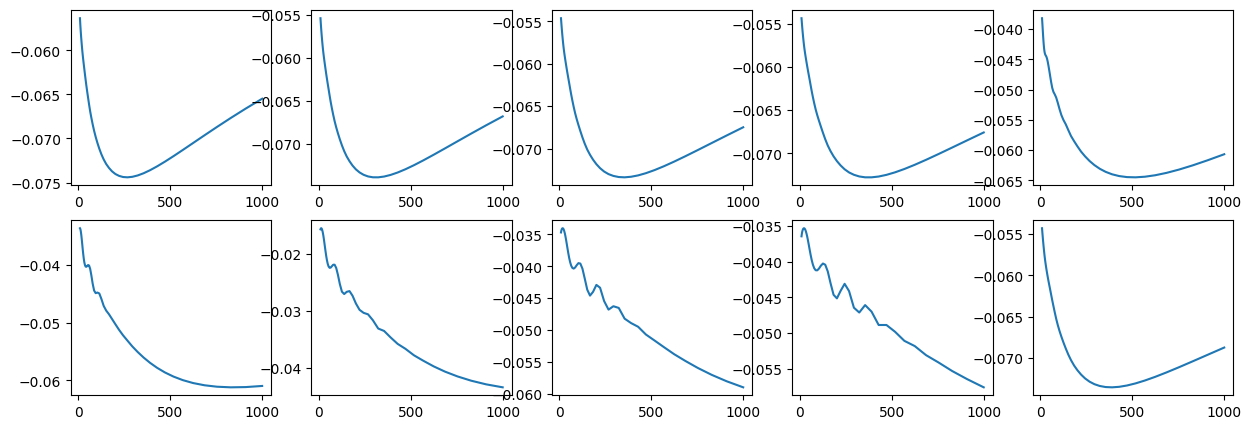

In [4]:
## Create one with late-time modification (bin); keep others the same as planck15
from jax_cosmo.core import Cosmology

_z_bin = onp.array([0.,   1.0, 5])
_k_bin = onp.array([0.025, 0.8, 5])


# cosmo_modified = Cosmology(Omega_c=0.2589, Omega_b=0.04860, h=0.6774, n_s=0.9667, sigma8=0.8159, Omega_k=0.0, w0=-1.0, wa=0.0,
#                            #gamma = 0.056)
#                            a_late=[0.1, 0.1, 0.2, 0.3], z_mod_form="bin")
#                            #a_late=[0.05, 0.03], z_mod_form="test")
    
cosmo_modified1 = Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1.0, # Fix w0=-1
                          Omega_k=0., wa=0.,
                           # a_late=[0,  0.2, 0.2,       0.1,  0.1, ], z_mod_form="bin_fixed",
                           # b_late=[0.01,  0.01, 0.01,       0.01,  0.01, ],  k_mod_form="bin_fixed", )
                           a_late=[0.,  0.,  0., 0.,  0., ], z_mod_form="bin_fixed",
                           b_late=[0.,  0.,  0., 0.,  0., ],  k_mod_form="bin_fixed", )


# You can inspect the documentation to see the 
# meaning of these positional arguments

dz =  [0.0,0.0,0.0,0.0]
A = 0.5
eta = 0.0
bias = [1.2, 1.4, 1.6, 1.8, 2.0]
m = [0.0,0.0,0.0,0.0]

nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
            for nzi, dzi in zip(nzs_s, dz)]

# Define IA model, z0 is fixed
b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
# Bias for the lenses
b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

# Define the lensing and number counts probe
probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                ia_bias=b_ia,
                                multiplicative_bias=m),
         jc.probes.NumberCounts(nzs_l, b)]

ell = np.logspace(1,3) # Defines a range of \ell

# And compute the data vector
cls_P15 = jc.angular_cl.angular_cl(cosmo_P15, ell, probes)


# Cls for modified cosmology
cls_modified1 = jc.angular_cl.angular_cl(cosmo_modified1, ell, probes)


residue1 = (cls_modified1 - cls_P15) / cls_P15

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, residue1[i*5 + j])

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


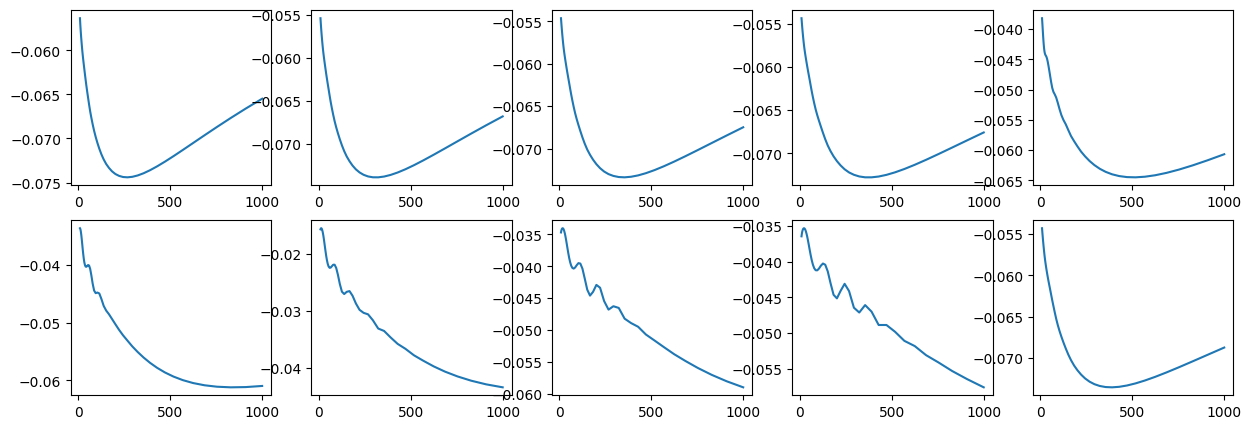

In [5]:
# Create one with late-time modification (bin); keep others the same as planck15
from jax_cosmo.core import Cosmology

_z_bin = onp.array([0.0,   1.0, 5])
_k_bin = onp.array([0.025, 0.8, 5])
# _k_bin = onp.array([-2, 0, 5]) 

tmpa = np.array([0. for i in range(int(_z_bin[2]))])
print(tmpa)
tmpb = np.array([0. for i in range(int(_k_bin[2]))])
print(tmpb)

cosmo_modified2 = Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1.0, # Fix w0=-1
                          Omega_k=0., wa=0.,
                         a_late=tmpa, z_mod_form="bin_custom", z_bin=_z_bin,
                         b_late=tmpb, k_mod_form="bin_custom", k_bin=_k_bin)

# You can inspect the documentation to see the 
# meaning of these positional arguments


dz =  [0.0,0.0,0.0,0.0]
A = 0.5
eta = 0.0
bias = [1.2, 1.4, 1.6, 1.8, 2.0]
m = [0.0,0.0,0.0,0.0]


nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
            for nzi, dzi in zip(nzs_s, dz)]

# Define IA model, z0 is fixed
b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
# Bias for the lenses
b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

# Define the lensing and number counts probe
probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                ia_bias=b_ia,
                                multiplicative_bias=m),
         jc.probes.NumberCounts(nzs_l, b)]

ell = np.logspace(1,3) # Defines a range of \ell

# And compute the data vector
cls_P15 = jc.angular_cl.angular_cl(cosmo_P15, ell, probes)


# Cls for modified cosmology
cls_modified2 = jc.angular_cl.angular_cl(cosmo_modified2, ell, probes)


residue2 = (cls_modified2 - cls_P15) / cls_P15

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, residue2[i*5 + j])

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

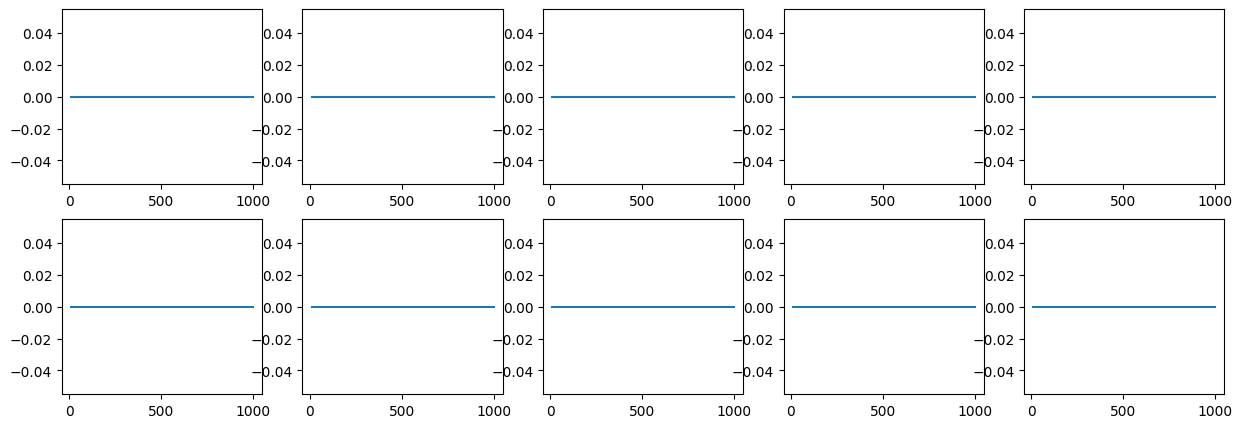

In [6]:
test = residue1-residue2

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, test[i*5 + j])
test

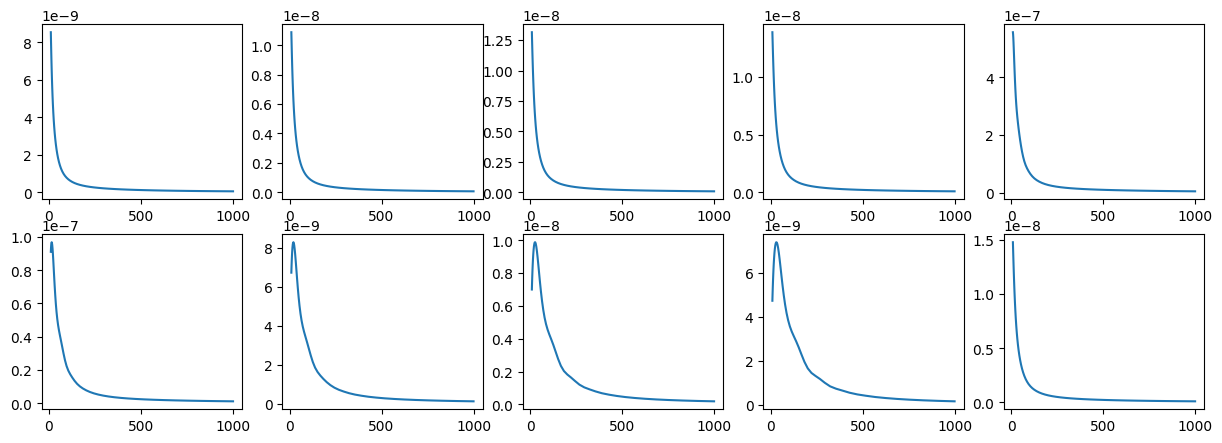

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, cls_modified1[i*5 + j])

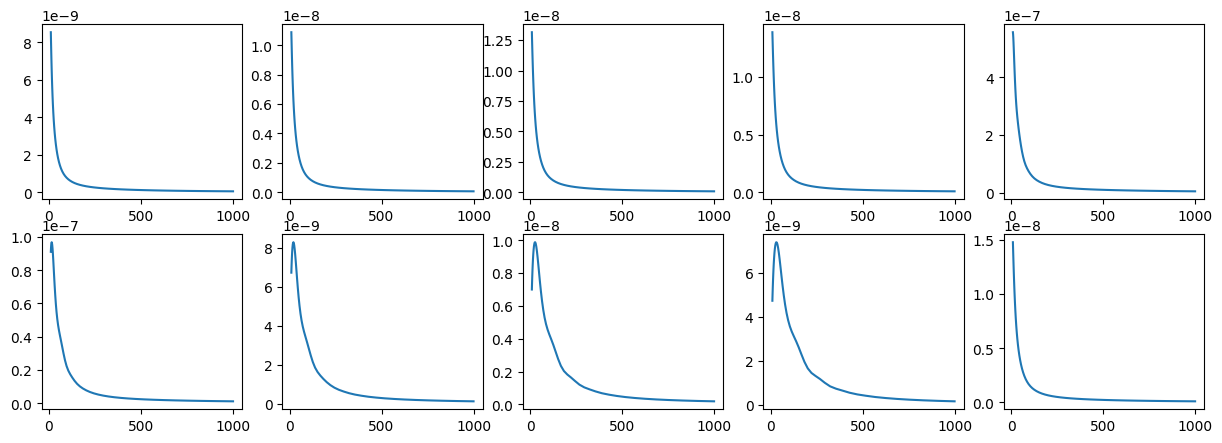

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, cls_modified2[i*5 + j])

In [9]:
cls_modified1[0]

Array([8.5445464e-09, 8.0594633e-09, 7.5617228e-09, 7.0588460e-09,
       6.5585488e-09, 6.0663083e-09, 5.5879061e-09, 5.1269833e-09,
       4.6869553e-09, 4.2700035e-09, 3.8777639e-09, 3.5105143e-09,
       3.1680409e-09, 2.8498801e-09, 2.5556224e-09, 2.2846329e-09,
       2.0362358e-09, 1.8100351e-09, 1.6055292e-09, 1.4217086e-09,
       1.2574954e-09, 1.1120211e-09, 9.8393260e-10, 8.7155083e-10,
       7.7312995e-10, 6.8681139e-10, 6.1105160e-10, 5.4448257e-10,
       4.8588611e-10, 4.3440479e-10, 3.8915729e-10, 3.4917114e-10,
       3.1368308e-10, 2.8212871e-10, 2.5393776e-10, 2.2863812e-10,
       2.0585141e-10, 1.8525044e-10, 1.6656133e-10, 1.4956397e-10,
       1.3407211e-10, 1.1993476e-10, 1.0702774e-10, 9.5246741e-11,
       8.4503890e-11, 7.4724865e-11, 6.5843990e-11, 5.7802381e-11,
       5.0545863e-11, 4.4023240e-11], dtype=float32)

In [10]:
cls_modified2[0]

Array([8.5445464e-09, 8.0594633e-09, 7.5617228e-09, 7.0588460e-09,
       6.5585488e-09, 6.0663083e-09, 5.5879061e-09, 5.1269833e-09,
       4.6869553e-09, 4.2700035e-09, 3.8777639e-09, 3.5105143e-09,
       3.1680409e-09, 2.8498801e-09, 2.5556224e-09, 2.2846329e-09,
       2.0362358e-09, 1.8100351e-09, 1.6055292e-09, 1.4217086e-09,
       1.2574954e-09, 1.1120211e-09, 9.8393260e-10, 8.7155083e-10,
       7.7312995e-10, 6.8681139e-10, 6.1105160e-10, 5.4448257e-10,
       4.8588611e-10, 4.3440479e-10, 3.8915729e-10, 3.4917114e-10,
       3.1368308e-10, 2.8212871e-10, 2.5393776e-10, 2.2863812e-10,
       2.0585141e-10, 1.8525044e-10, 1.6656133e-10, 1.4956397e-10,
       1.3407211e-10, 1.1993476e-10, 1.0702774e-10, 9.5246741e-11,
       8.4503890e-11, 7.4724865e-11, 6.5843990e-11, 5.7802381e-11,
       5.0545863e-11, 4.4023240e-11], dtype=float32)

In [11]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_P15, ell, probes, sparse=True);

temperature= 2
cov = cov*temperature

# Compile a function that computes the Hessian of the likelihood
hessian_loglik = data = mu # We create some fake data from the fiducial cosmology
# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.

# Note the `jit` decorator for just in time compilation, this makes your code
# run fast on GPU :-)
@jax.jit
def likelihood_late(p):
  # Create a new cosmology at these parameters

    cosmo = Cosmology(Omega_c=0.2589, Omega_b=0.04860, h=0.6774, n_s=0.9667, Omega_k=0.0, w0=-1.0, wa=0,
                      sigma8=0.78,  #sigma8=0.8159, 
                           #gamma = 0.056)
                           a_late=[p[0], p[1], 0, 0 ],  z_mod_form="bin")
                           #a_late=[p[0], p[1] ],  z_mod_form="test")

    # cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])

    # Compute mean and covariance of angular Cls
    m, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, sparse=True)
    
    temperature= 1
    C = C*temperature

    # Return likelihood value assuming constant covariance, so we stop the gradient
    # at the level of the precision matrix, and we will not include the logdet term
    # in the likelihood
    P = jc.sparse.inv(jax.lax.stop_gradient(C))
    r = data - m
    return -0.5 * r.T @ jc.sparse.sparse_dot_vec(P, r)



In [12]:
# Compile a function that computes the Hessian of the likelihood

params_late = np.array([0.0, 0.0]) 
#params_late = np.array([cosmo_modified.Omega_c, cosmo_P15.sigma8]) 

#params_late = np.array([cosmo_modified.w0, cosmo_P15.wa]) 

hessian_loglik_late = jax.jit(jax.hessian(likelihood_late))

# Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
# This is a bit slow at first....
F_late = - hessian_loglik_late(params_late)

In [13]:
#@title Defining some plotting functions [run me]

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    """
    def eigsorted(cov):
        vals, vecs = linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    mat = fisher
    cov = np.linalg.inv(mat)
    sigma_marg = lambda i: np.sqrt(cov[i, i])

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    print("kz testing", nstd)
    print("kz testing2", vals)
    vals = np.absolute(vals)
    width, height = 2 * nstd * sqrt(vals)
    ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(0)
    s2 = 1.5*nstd*sigma_marg(1)
    ax.set_xlim(pos[0] - s1, pos[0] + s1)
    ax.set_ylim(pos[1] - s2, pos[1] + s2)
    plt.draw()
    return ellip

kz testing 1
kz testing2 [nan nan]
fisher= [[-0. -0.]
 [-0. -0.]]
cov= [[ nan  nan]
 [ nan -inf]]
vals= [nan nan]
vecs= [[nan nan]
 [nan nan]]


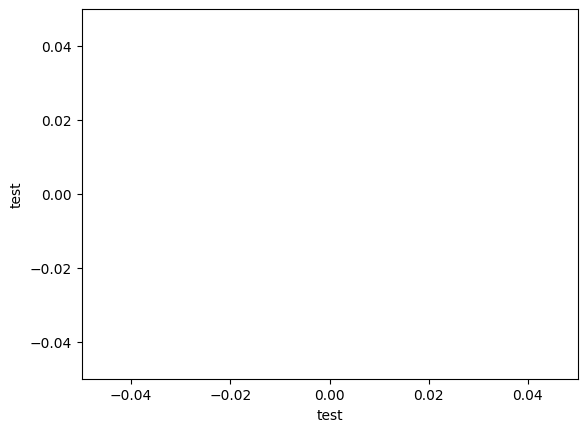

In [14]:
# We can now plot contours obtained with this

plot_contours(F_late, params_late, fill=False, nstd=1);
xlabel('test')
ylabel('test');

print("fisher=",F_late)
print("cov=",np.linalg.inv(F_late))
vals, vecs = linalg.eigh(np.linalg.inv(F_late))
print("vals=", vals)
print("vecs=", vecs)

In [15]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [Array(1., dtype=float32),
  Array(2., dtype=float32),
  Array(3., dtype=float32),
  Array(4., dtype=float32)],
 [Array(5., dtype=float32),
  Array(6., dtype=float32),
  Array(7., dtype=float32),
  Array(8., dtype=float32)],
 [Array(1., dtype=float32), Array(2., dtype=float32)])

In [16]:
@jax.jit
def model_fn(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
    return cl.flatten()

In [17]:
# Let's define our model using numpyro
def model():
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.9))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.97))
    w0 = -1.0
    
    # our late-time modification
    a1 = numpyro.sample('a1', dist.Uniform(-0.5, +0.5))
    a2 = numpyro.sample('a2', dist.Uniform(-0.5, +0.5))
    
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    
    # Astrophysical params
    A = numpyro.sample('A', dist.Uniform(-5., 5.))
    eta = numpyro.sample('eta', dist.Uniform(-5., 5.))
    
    # Now that params are defined, here is the forward model
    cosmo = FiducialCosmo(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, a_late=[0, 0, 0.0, 0.0], z_mod_form="bin")
    
    signal = model_fn(get_params_vec(cosmo, m, [dz1, dz2, dz3, dz4], [A, eta]))
    
    # And here we define the likelihood
    numpyro.sample('cl_wl', dist.MultivariateNormal(signal, C))

In [18]:
from numpyro.handlers import seed, trace
rng_key = jax.random.PRNGKey(0)

In [19]:
tr = numpyro.handlers.trace(seed(model, rng_key))

In [20]:
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.,a_late=[0.0, 0.0, 0.0, 0.0], z_mod_form="bin")

In [21]:
#KZ: there's a bug here, let's investigate how to use hmc, or nuts in anonther notebook...
res = tr.get_trace()

NameError: name 'nzs' is not defined